# 🧭 Assignment 6 Workflow: Knock Airport Weather Analysis

This notebook guides you through analysing hourly weather data from Knock Airport, using temperature trends. The dataset is sourced from [Met Éireann](https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv) and includes metadata that must be handled carefully.

## ✅ Workflow Summary

1. **Inspect the raw CSV file manually or programmatically**  
   Preview the file to identify where the actual header begins. This is typically the row starting with `"station"`.

2. **Detect and skip metadata rows**  
   Use Python logic to locate the header row and skip all preceding lines when loading the dataset.

3. **Download and save the file locally**  
   Save the CSV file to a `data/` folder to ensure reproducibility and consistent access throughout the analysis.

4. **Load the dataset from the saved file**  
   Read the file from disk using `pandas.read_csv()` and apply the detected header logic to load the data accurately.

5. **Validate the dataset after loading**  
   Check column names, data types, and missing values to confirm the structure is correct and ready for analysis.

6. **Perform analysis and visualisation**  
   - Plot hourly temperature - this will focus on temperatures between dates 10/07/2025 and 16/07/2025. The hottest week of the year!
   - Calculate and plot daily mean temperature  
   - Calculate and plot monthly mean temperature

📌 Each step is explained in detail throughout the notebook to support your understanding and ensure reproducibility.



## 📘 Step 1 – Inspect the Raw CSV File (Manual or Programmatic)

Before loading the dataset, it's essential to understand its structure. The Met Éireann CSV file includes metadata rows before the actual header, which can interfere with parsing and analysis.

You can inspect the file manually by downloading it from the following URL:

https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv



Open it using your default spreadsheet viewer or a plain text editor. Look for the row that begins with `"station"` — this marks the start of the structured data table.

Alternatively, preview the file programmatically using Python:

```python
import requests
url = "https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv"
response = requests.get(url)
print('\n'.join(response.text.splitlines()[:30]))
```

This will print the first 30 lines of the file, allowing you to identify metadata rows, delimiters, and the header position.

**📌 Why this matters:** Inspecting the raw structure ensures that you correctly detect and skip metadata rows, improving reproducibility and preventing parsing errors.

## Step 2: Install Libraries

In [1]:
# ✅ Confirm required packages are installed (uncomment %pip lines below if needed)
import importlib.util

def ensure_package(package_name, pip_name=None):
    if importlib.util.find_spec(package_name) is None:
        pip_name = pip_name or package_name
        print(f"📦 '{package_name}' not found. Uncomment the line below to install it:")
        print(f"# %pip install {pip_name}")
    else:
        print(f"✅ '{package_name}' is already installed.")

# Check key packages
ensure_package("ipywidgets")
# %pip install ipywidgets

ensure_package("jinja2")
# %pip install jinja2

# Note: %pip install only works in Jupyter notebooks. Use pip install in terminal for scripts.

# 📚 Import essential libraries
import pandas as pd  # data manipulation : https://pandas.pydata.org/
import requests  # HTTP requests : https://docs.python-requests.org/
from io import StringIO  # in-memory text streams : https://docs.python.org/3/library/io.html#io.StringIO
import os  # operating system functionality : https://docs.python.org/3/library/os.html
import numpy as np  # numerical operations : https://numpy.org/
import seaborn as sns  # statistical data visualisation : https://seaborn.pydata.org/
from datetime import datetime, timedelta  # date and time handling : https://docs.python.org/3/library/datetime.html
import matplotlib.pyplot as plt  # data visualisation : https://matplotlib.org/
import matplotlib.dates as mdates  # datetime axis formatting : https://matplotlib.org/stable/users/prev_whats_new/whats_new_3.1.0.html#dates
from matplotlib.dates import WeekdayLocator, DateFormatter, MO
from matplotlib.table import Table  # table creation in plots : https://matplotlib.org/stable/api/table_api.html
from ipywidgets import interact, widgets  # interactive sliders/dropdowns : https://ipywidgets.readthedocs.io/
from IPython.display import display, HTML  # display HTML in notebooks : https://ipython.readthedocs.io/en/stable/api/generated/IPython.display.html
from pathlib import Path  # modern, object-oriented way to handle file system paths : https://docs.python.org/3/library/pathlib.html


✅ 'ipywidgets' is already installed.
✅ 'jinja2' is already installed.


## Helper functions



In [38]:
# Helper function to detect datetime format
def detect_datetime_format(samples, formats, dayfirst=True):
    """
    Detects the most likely datetime format from a list of samples.

    Parameters:
        samples (list): List of date strings
        formats (list): List of datetime format strings to test
        dayfirst (bool): Whether to interpret day as first in ambiguous dates

    Returns:
        str or None: Matching format string, or None if no match
    """
    import pandas as pd
    for fmt in formats:
        parsed = pd.to_datetime(samples, format=fmt, dayfirst=dayfirst, errors='coerce')
        if parsed.notna().sum() >= max(1, int(len(samples) * 0.7)):
            return fmt
    return None

# Helper function to parse datetime column with format detection
def parse_datetime_column(df, date_col, candidate_formats=None, dayfirst=True):
    """
    Attempts to parse a datetime column using candidate formats.
    Falls back to pandas/dateutil parsing if no format matches.

    Parameters:
        df (pd.DataFrame): Input dataframe
        date_col (str): Name of the column containing date strings
        candidate_formats (list): Optional list of datetime formats to try
        dayfirst (bool): Whether to interpret day as first in ambiguous dates

    Returns:
        pd.Series: Parsed datetime column
    """
    import pandas as pd
    import warnings

    if candidate_formats is None:
        candidate_formats = [
            '%Y-%m-%d %H:%M:%S', '%Y-%m-%d %H:%M', '%d-%b-%Y %H:%M',
            '%d/%m/%Y %H:%M:%S', '%d/%m/%Y %H:%M', '%d-%m-%Y %H:%M',
            '%d %b %Y %H:%M', '%d %B %Y %H:%M',
        ]

    sample_vals = df[date_col].dropna().astype(str).head(80).tolist()
    chosen_fmt = detect_datetime_format(sample_vals, candidate_formats, dayfirst=dayfirst)

    if chosen_fmt:
        print(f"✅ Detected datetime format: {chosen_fmt}")
        return pd.to_datetime(df[date_col], format=chosen_fmt, dayfirst=dayfirst, errors='coerce')
    else:
        print("⚠️ No single format matched. Falling back to flexible parsing.")
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore', message='Could not infer format')
            return pd.to_datetime(df[date_col], dayfirst=dayfirst, errors='coerce')

# Helper function to parse temperature column
def parse_temperature_column(df, col_name='temp'):
    """
    Ensures temperature column is numeric and named 'temp'.
    """
    if col_name not in df.columns:
        col_name = next((c for c in df.columns if 'temp' in c.lower()), None)
        if col_name is None:
            raise KeyError("No temperature column found.")
    df['temp'] = pd.to_numeric(df[col_name], errors='coerce')
    return df

# Helper function to load cleaned weather data
def load_cleaned_weather_data(filepath="data/assignment06_climate_data.csv"):
    """
    Loads the cleaned weather dataset from a local CSV file.

    Parameters:
        filepath (str or Path): Path to the CSV file

    Returns:
        pd.DataFrame: Loaded DataFrame with stripped column names
    """
    import pandas as pd
    from pathlib import Path

    filepath = str(filepath)  # ✅ Ensure compatibility with Path objects
    df = pd.read_csv(filepath, low_memory=False)
    df.columns = df.columns.str.strip()
    return df


# Helper function to define Irish seasons as a DataFrame
def define_irish_seasons(year=2025):
    """
    Returns a DataFrame of Irish seasonal boundaries for a given year.

    Parameters:
        year (int): The target year for seasonal definitions

    Returns:
        pd.DataFrame: A DataFrame with columns ['season', 'start', 'end']
    """
    import pandas as pd

    data = [
        ("Winter", pd.Timestamp(f"{year-1}-12-01 00:00"), pd.Timestamp(f"{year}-02-28 23:59")),
        ("Spring", pd.Timestamp(f"{year}-03-01 00:00"), pd.Timestamp(f"{year}-05-31 23:59")),
        ("Summer", pd.Timestamp(f"{year}-06-01 00:00"), pd.Timestamp(f"{year}-08-31 23:59")),
        ("Autumn", pd.Timestamp(f"{year}-09-01 00:00"), pd.Timestamp(f"{year}-11-30 23:59")),
    ]

    return pd.DataFrame(data, columns=["season", "start", "end"])


# Helper function to prepare temperature data for a given date range
def prepare_temperature_data(df, start_date, end_date, season_bounds=None):
    """
    Filters and prepares temperature data for a given date range.

    Parameters:
        df (pd.DataFrame): Input weather data
        start_date (pd.Timestamp): Start of the custom range
        end_date (pd.Timestamp): End of the custom range
        season_bounds (dict, optional): Seasonal boundaries for validation (not enforced)

    Returns:
        pd.DataFrame: Filtered and enriched temperature data
    """
    df = df.copy()
    df.columns = df.columns.str.strip()

    if 'date' not in df.columns:
        raise KeyError("Expected 'date' column not found in DataFrame.")

    # Parse datetime column with fallback
    try:
        df['datetime'] = pd.to_datetime(df['date'], format='%d-%b-%Y %H:%M', errors='raise')
    except Exception:
        df['datetime'] = pd.to_datetime(df['date'], errors='coerce')

    df = df.dropna(subset=['datetime'])

    # Use start_date and end_date directly (already Timestamp objects)
    start_ts = start_date
    end_ts = end_date
    mask = (df['datetime'] >= start_ts) & (df['datetime'] <= end_ts)
    range_df = df.loc[mask].copy()

    # Extract date and hour for pivoting
    range_df['date'] = range_df['datetime'].dt.date
    range_df['hour'] = range_df['datetime'].dt.strftime('%H:%M')

    return range_df.sort_values('datetime').reset_index(drop=True)


# Helper function to get custom date range from user input
def get_custom_range(start_str, end_str):
    try:
        start = pd.to_datetime(start_str)
        end = pd.to_datetime(end_str)
        if start > end:
            raise ValueError("Start date must be before end date.")
        return start, end
    except Exception as e:
        print(f"❌ Invalid date range: {e}")
        return None, None


## 🔍 Step 3 – Detect and Skip Metadata Rows from Raw CSV

Although the header row was visually confirmed earlier, this step ensures reproducibility by detecting it programmatically.

The following code reads the raw CSV file line by line to locate the actual header row — typically the line that begins with "station". Once detected, it skips all preceding metadata rows and saves a cleaned version of the file containing only structured tabular data.

This approach improves robustness, avoids hardcoding assumptions about the file structure, and prepares the dataset for reliable loading with pandas. If no valid header is found, the script defaults to using the first line and issues a warning.


In [3]:
# Define output path for cleaned CSV
DATA_PATH = Path("data/assignment06_climate_data.csv")

# Download raw CSV from Met Éireann
url = "https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv"
response = requests.get(url)

# ✅ Check for successful response
if response.status_code != 200:
    raise RuntimeError(f"❌ Failed to download data: HTTP {response.status_code}")

# Split response into lines
lines = response.text.splitlines()

# Detect header row using known markers
header_index = next(
    (i for i, line in enumerate(lines) if line.strip().lower().startswith("station") and "," in line),
    None
)

# Fallback: look for any line containing 'date,'
if header_index is None:
    header_index = next(
        (i for i, line in enumerate(lines) if "date," in line.lower()),
        None
    )

# Default to first line if no header is found
if header_index is None:
    print("⚠️ Warning: header row not found. Defaulting to first line.")
    header_index = 0

# ✅ Print detected header row for confirmation
print(f"✅ Header row detected at line {header_index}:")
print(lines[header_index])


✅ Header row detected at line 23:
date,ind,rain,ind,temp,ind,wetb,dewpt,vappr,rhum,msl,ind,wdsp,ind,wddir,ww,w,sun,vis,clht,clamt


## 📁 Step 4: Save the File

To keep the workflow reproducible and organised, we save the downloaded CSV file to a `data/` folder located one level above the notebook. This allows us to reuse the file without re-downloading and ensures that all analysis references a consistent local copy.

📌 *Reference: [Saving files locally supports reproducibility and version control in data science workflows.](https://www.geeksforgeeks.org/machine-learning/explain-data-versioning/)*



In [4]:
# Ensure 'data' folder exists
DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Save cleaned CSV to 'data' folder
with open(DATA_PATH, "w", encoding="utf-8") as f:
    for line in lines[header_index:]:
        f.write(line + "\n")

print(f"📁 Saved cleaned climate data to: {DATA_PATH.resolve()}")


📁 Saved cleaned climate data to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_climate_data.csv


## 📥 Step 5: Load the Dataset from the Saved File

The cleaned CSV file has already been saved locally with metadata rows removed. In this step, we load the file directly from disk and confirm that the header row is correctly positioned at the top of the file.

This ensures consistent access to structured data and avoids repeated downloads or manual inspection.


In [5]:
df = load_cleaned_weather_data()
df.head()


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.3,wdsp,ind.4,wddir,ww,w,sun,vis,clht,clamt
0,10-apr-1996 14:00,0,0.0,0,11.5,0,8.1,3.9,0.0,0,...,0,0,0,0,25,81,0.0,35000,32,5
1,31-jul-1996 08:00,0,0.0,0,11.5,0,11.1,10.7,0.0,0,...,0,0,0,0,25,82,0.0,40000,45,5
2,31-jul-1996 09:00,0,0.0,0,11.6,0,10.7,9.8,0.0,0,...,0,0,0,0,80,81,0.0,8000,32,7
3,31-jul-1996 10:00,0,0.0,0,12.9,0,11.3,9.8,0.0,0,...,0,0,0,0,25,82,0.0,28000,35,6
4,31-jul-1996 11:00,0,0.0,0,14.5,0,10.8,7.0,0.0,0,...,0,0,0,0,2,11,0.0,40000,40,6


## ✅ Step 6: Validate the Dataset After Loading

After loading the dataset, it's important to confirm that the structure is correct and the data is usable. This includes:

- Checking column names
- Inspecting data types
- Identifying missing values


In [6]:
# Check column names
print("Column names:", df.columns.tolist())

# Check data types
print("\nData types:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())
print(f"\n📐 DataFrame shape: {df.shape[0]} rows × {df.shape[1]} columns")



Column names: ['date', 'ind', 'rain', 'ind.1', 'temp', 'ind.2', 'wetb', 'dewpt', 'vappr', 'rhum', 'msl', 'ind.3', 'wdsp', 'ind.4', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht', 'clamt']

Data types:
date      object
ind        int64
rain      object
ind.1      int64
temp     float64
ind.2      int64
wetb     float64
dewpt    float64
vappr    float64
rhum       int64
msl       object
ind.3      int64
wdsp      object
ind.4      int64
wddir     object
ww        object
w         object
sun      float64
vis       object
clht      object
clamt     object
dtype: object

Missing values per column:
date     0
ind      0
rain     0
ind.1    0
temp     0
ind.2    0
wetb     0
dewpt    0
vappr    0
rhum     0
msl      0
ind.3    0
wdsp     0
ind.4    0
wddir    0
ww       0
w        0
sun      0
vis      0
clht     0
clamt    0
dtype: int64

📐 DataFrame shape: 256434 rows × 21 columns


## Article: Summer of 2025 becomes warmest season on record in Ireland

https://www.irishtimes.com/environment/2025/09/03/summer-of-2025-becomes-warmest-season-on-record-in-ireland/

> **Sustained heat**, especially at night, contributed to higher than normal average temperatures.  
>  
> This summer was **Ireland’s warmest season since records began in 1900**, according to provisional data from **Met Éireann**.  
>  
> **Met Éireann climatologist Paul Moore** said:  
> *“Ireland is experiencing the effects of climate change, and our climate projections show that our climate is going to become warmer.”*

> The hottest week of Summer 2025 in Ireland was July 10–16, with peak temperatures reaching 31°C on Saturday, July 12. This was part of a short-lived heatwave driven by the Azores High, affecting multiple stations including Knock Airport.  

> Knock Airport: Recorded 28.7°C — its highest July temperature on record
> https://www.breakingnews.ie/ireland/july-2025-was-9th-hottest-on-record-with-highest-temperature-of-31-degrees-1789636.html



### Meteorological Seasons in Ireland for 2025

We first define the meteorological seasons for Ireland in 2025:

https://www.met.ie/education/outreach-irish-seasons

In [7]:
seasons_2025 = define_irish_seasons()
print("📅 Irish Seasons for 2025:")
for _, row in seasons_2025.iterrows():
    print(f"  {row['season']}: {row['start'].strftime('%d-%b-%Y %H:%M')} → {row['end'].strftime('%d-%b-%Y %H:%M')}")


📅 Irish Seasons for 2025:
  Winter: 01-Dec-2024 00:00 → 28-Feb-2025 23:59
  Spring: 01-Mar-2025 00:00 → 31-May-2025 23:59
  Summer: 01-Jun-2025 00:00 → 31-Aug-2025 23:59
  Autumn: 01-Sep-2025 00:00 → 30-Nov-2025 23:59


### Define Date Range

We will focus on the hottest week of the year: July 10–16, 2025 by customising date ranges in our analysis and outlines which season a date range falls into.

In [8]:
# Define custom date range using helper
custom_start, custom_end = get_custom_range("2025-07-10", "2025-07-16 23:59")

# Validate and fallback if needed
if custom_start is None or custom_end is None:
    print("⚠️ Invalid custom range returned by get_custom_range(); falling back to defaults.")
    custom_start = pd.Timestamp("2025-07-10")
    custom_end = pd.Timestamp("2025-07-16")

# Check which season the custom range falls into
matched_season = None
for _, row in seasons_2025.iterrows():
    if row["start"] <= custom_start <= row["end"] and row["start"] <= custom_end <= row["end"]:
        matched_season = row["season"]
        break

if matched_season:
    print(f"📆 The custom range falls entirely within: {matched_season}")
else:
    print("⚠️ The custom range spans multiple seasons or falls outside defined bounds.")

# Prepare filtered data
range_df = prepare_temperature_data(df, custom_start, custom_end)


📆 The custom range falls entirely within: Summer


## 🧪 Load, Filter, and Prepare Temperature Data

This function takes a raw weather dataset and prepares it for time-series analysis. It performs the following steps:

- Cleans column names and identifies the correct datetime and temperature columns.
- Uses robust logic to detect and parse datetime formats, falling back to flexible parsing if needed.
- Validates that the selected date range falls within a defined meteorological season.
- Filters the dataset to the specified date range and extracts hourly temperature readings.

This step ensures the data is clean, consistent, and ready for visualisation.


### 📦 Step 1: Load Weather Data and Define Custom Date Range

Load the cleaned dataset and use the helper to define and validate the custom date range.


In [9]:
# Prepare filtered temperature data using helper
range_df = prepare_temperature_data(df, custom_start, custom_end)

if not range_df.empty:
    print(f"✅ Filtered data contains {len(range_df)} rows.")
    display(range_df.head())

    # Create pivot table (hourly temperature by date)
    pivot = range_df.pivot(index='hour', columns='date', values='temp')

    # Reindex to include all dates in the selected range
    try:
        # If custom_start/custom_end are missing, infer from the filtered data
        if custom_start is None or custom_end is None:
            inferred_start = pd.to_datetime(range_df['datetime'].min()).date()
            inferred_end = pd.to_datetime(range_df['datetime'].max()).date()
            print(f"ℹ️ custom_start/custom_end missing — inferring range from data: {inferred_start} → {inferred_end}")
            start_date = inferred_start
            end_date = inferred_end
        else:
            # Accept pandas Timestamp or python date-like objects
            start_date = custom_start.date() if hasattr(custom_start, "date") else pd.to_datetime(custom_start).date()
            end_date = custom_end.date() if hasattr(custom_end, "date") else pd.to_datetime(custom_end).date()

        full_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        cols = [d.date() for d in full_dates]
        pivot = pivot.reindex(columns=cols)
    except Exception as e:
        print(f"❌ Error generating full date range: {e}")
        # Don't raise — keep the existing pivot if reindexing fails
        pass

    print(f"📊 Pivot table includes {len(pivot.columns)} days and {len(pivot.index)} hourly slots.")
    display(pivot.style.format("{:.1f}").background_gradient(cmap='YlOrRd', axis=None))

else:
    print("⚠️ No data found for the selected date range.")


✅ Filtered data contains 168 rows.


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.4,wddir,ww,w,sun,vis,clht,clamt,datetime,hour
0,2025-07-10,0,0.0,0,13.9,0,13.8,13.8,15.7,99,...,2,200,,,0.0,2000,1,8,2025-07-10 00:00:00,00:00
1,2025-07-10,3,0.0,0,13.7,0,13.7,13.7,15.7,100,...,2,190,,,0.0,300,2,8,2025-07-10 01:00:00,01:00
2,2025-07-10,0,0.0,0,13.6,0,13.6,13.6,15.6,100,...,2,190,,,0.0,4100,1,8,2025-07-10 02:00:00,02:00
3,2025-07-10,0,0.0,0,13.9,0,13.9,13.9,15.9,100,...,2,180,,,0.0,1200,1,8,2025-07-10 03:00:00,03:00
4,2025-07-10,0,0.0,0,14.0,0,14.0,14.0,16.0,100,...,2,180,,,0.0,1700,1,8,2025-07-10 04:00:00,04:00


📊 Pivot table includes 7 days and 24 hourly slots.


date,2025-07-10,2025-07-11,2025-07-12,2025-07-13,2025-07-14,2025-07-15,2025-07-16
hour,,,,,,,
00:00,13.9,15.5,15.2,19.2,15.5,12.3,11.3
01:00,13.7,14.8,14.7,18.2,15.7,12.8,10.6
02:00,13.6,14.5,15.0,17.2,14.6,12.7,10.2
03:00,13.9,13.5,14.4,16.9,13.6,12.5,10.2
04:00,14.0,12.8,14.3,16.6,13.3,12.5,10.5
05:00,14.0,13.3,13.5,16.6,13.3,12.3,9.6
06:00,14.3,14.1,15.0,17.8,13.1,12.3,11.6
07:00,15.8,15.9,16.7,18.7,13.5,12.6,12.7
08:00,17.0,16.9,19.3,20.5,12.1,13.6,14.0


### 📤 Save CSV and 📈 Plot Temperature Trends

This step saves the filtered temperature data to a CSV file for future reference and generates plots to visualise temperature trends over the selected date range.

In [13]:
# Ensure output folders exist
Path("data").mkdir(parents=True, exist_ok=True)
Path("plots").mkdir(parents=True, exist_ok=True)

# Save filtered data to CSV
csv_path = Path("data") / f"assignment06_temperature_range.csv"
range_df.to_csv(csv_path, index=False)
print(f"✅ Saved filtered data to: {csv_path.resolve()}")


✅ Saved filtered data to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_temperature_range.csv


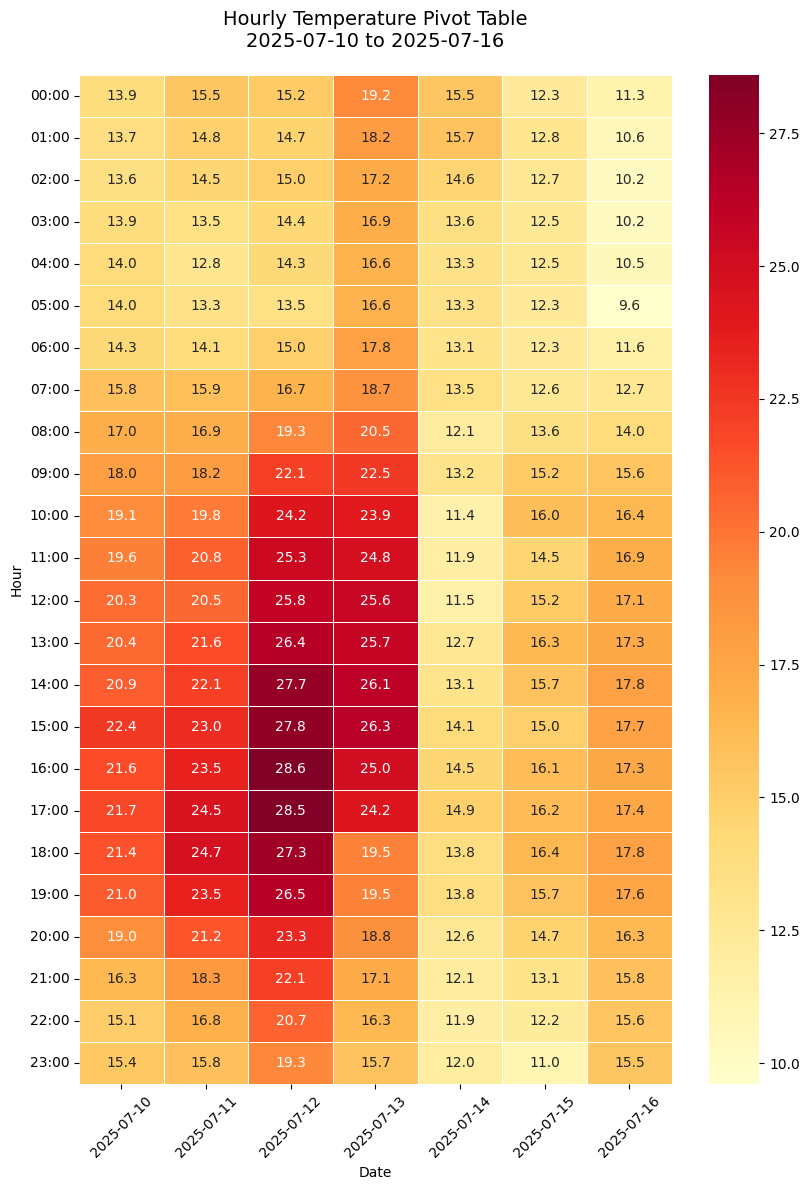

🖼️ Saved pivot table image to: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\plots\assignment06_hourly_temperature_pivot_table_2025-07-10_to_2025-07-16.png


In [16]:
# Ensure plots folder exists
Path("plots").mkdir(parents=True, exist_ok=True)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(1.2 * len(pivot.columns), 0.5 * len(pivot.index)))

# Use seaborn heatmap to mimic background_gradient
sns.heatmap(
    pivot,
    annot=True,
    fmt=".1f",
    cmap="YlOrRd",
    cbar=True,
    linewidths=0.5,
    linecolor="white",
    ax=ax
)

# Title and layout
ax.set_title(f"Hourly Temperature Pivot Table\n{start_date} to {end_date}", fontsize=14, pad=20)
ax.set_xlabel("Date")
ax.set_ylabel("Hour")
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
table_path = Path("plots") / f"assignment06_hourly_temperature_pivot_table_{start_date}_to_{end_date}.png"
plt.savefig(table_path, dpi=300)
plt.show()

print(f"🖼️ Saved pivot table image to: {table_path.resolve()}")


## 📈 Function: Interactive Daily Temperature Plot with Hourly Ledger

This function creates an interactive visualisation of hourly temperature data for each day in the date range 10/07/2025 to 16/07/2025. It enables users to:

- Select a specific date using a slider widget.
- View a line chart of hourly temperature readings for that day.
- See annotations for each temperature point and a horizontal line showing the daily average.
- Print a detailed ledger of hourly temperature values below the chart.

This interactive tool is ideal for exploring daily weather patterns, identifying temperature spikes, and comparing day-to-day variability. It uses `ipywidgets` for interactivity and `matplotlib` for plotting.


In [22]:
# Prepare filtered temperature data using helper
range_df = prepare_temperature_data(df, custom_start, custom_end)

if not range_df.empty:
    print(f"✅ Filtered data contains {len(range_df)} rows.")
    display(range_df.head())

    # Create pivot table (hourly temperature by date)
    pivot = range_df.pivot(index='hour', columns='date', values='temp')

    # Reindex to include all dates in the selected range
    try:
        if custom_start is None or custom_end is None:
            inferred_start = pd.to_datetime(range_df['datetime'].min()).date()
            inferred_end = pd.to_datetime(range_df['datetime'].max()).date()
            print(f"ℹ️ custom_start/custom_end missing — inferring range from data: {inferred_start} → {inferred_end}")
            start_date = inferred_start
            end_date = inferred_end
        else:
            start_date = custom_start.date() if hasattr(custom_start, "date") else pd.to_datetime(custom_start).date()
            end_date = custom_end.date() if hasattr(custom_end, "date") else pd.to_datetime(custom_end).date()

        full_dates = pd.date_range(start=start_date, end=end_date, freq='D')
        cols = [d.date() for d in full_dates]
        pivot = pivot.reindex(columns=cols)
    except Exception as e:
        print(f"❌ Error generating full date range: {e}")
        pass

    print(f"📊 Pivot table includes {len(pivot.columns)} days and {len(pivot.index)} hourly slots.")
    # Removed: display of styled pivot table

    # Ensure date column is in correct format
    if not pd.api.types.is_object_dtype(range_df['date']):
        range_df['date'] = pd.to_datetime(range_df['date']).dt.date

    date_list = sorted(range_df['date'].unique())

    # Save all plots daily based on range_df
     # Optional: Save all plots - change to False to disable
    save_plots = True
    plots_path = "plots"
    if save_plots:
        os.makedirs(plots_path, exist_ok=True)
        for selected_date in date_list:
            day_df = range_df[range_df['date'] == selected_date]
            if day_df.empty:
                continue

            avg_temp = day_df['temp'].mean()
            plt.figure(figsize=(12, 5))
            plt.plot(day_df['datetime'], day_df['temp'], label='Hourly Temperature', color='darkorange', marker='o')
            for x, y in zip(day_df['datetime'], day_df['temp']):
                plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)
            plt.axhline(avg_temp, color='blue', linestyle='--', label=f'Average: {avg_temp:.2f} °C')
            plt.title(f"Hourly Temperature – {selected_date} (Knock Airport)")
            plt.xlabel("Date and Time")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.xticks(rotation=45)
            filename = os.path.join(plots_path, f"assignment06_hourly_temperature_{selected_date}.png")
            plt.savefig(filename, dpi=300)
            plt.close()

    # Interactive plot function
    def plot_day(selected_date):
        day_df = range_df[range_df['date'] == selected_date]
        if day_df.empty:
            print(f"No data for {selected_date}")
            return

        avg_temp = day_df['temp'].mean()
        plt.figure(figsize=(12, 5))
        plt.plot(day_df['datetime'], day_df['temp'], label='Hourly Temperature', color='darkorange', marker='o')
        for x, y in zip(day_df['datetime'], day_df['temp']):
            plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)
        plt.axhline(avg_temp, color='blue', linestyle='--', label=f'Average: {avg_temp:.2f} °C')
        plt.title(f"Hourly Temperature – {selected_date} (Knock Airport)")
        plt.xlabel("Date and Time")
        plt.ylabel("Temperature (°C)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.xticks(rotation=45)
        plt.show()

        print(f"\n🧾 Hourly Ledger for {selected_date}:")
        print(day_df[['hour', 'temp']].round(1).to_string(index=False, justify='left', col_space=20))

    print("\n📅 Interactive Daily Charts:")
    interact(plot_day, selected_date=widgets.SelectionSlider(
        options=date_list,
        value=date_list[0],
        description='Select Date',
        continuous_update=False
    ))

else:
    print("⚠️ No data found for the selected date range.")


✅ Filtered data contains 168 rows.


,date,ind,rain,ind.1,temp,ind.2,wetb,dewpt,vappr,rhum,...,ind.4,wddir,ww,w,sun,vis,clht,clamt,datetime,hour
0,2025-07-10,0,0.0,0,13.9,0,13.8,13.8,15.7,99,...,2,200,,,0.0,2000,1,8,2025-07-10 00:00:00,00:00
1,2025-07-10,3,0.0,0,13.7,0,13.7,13.7,15.7,100,...,2,190,,,0.0,300,2,8,2025-07-10 01:00:00,01:00
2,2025-07-10,0,0.0,0,13.6,0,13.6,13.6,15.6,100,...,2,190,,,0.0,4100,1,8,2025-07-10 02:00:00,02:00
3,2025-07-10,0,0.0,0,13.9,0,13.9,13.9,15.9,100,...,2,180,,,0.0,1200,1,8,2025-07-10 03:00:00,03:00
4,2025-07-10,0,0.0,0,14.0,0,14.0,14.0,16.0,100,...,2,180,,,0.0,1700,1,8,2025-07-10 04:00:00,04:00


📊 Pivot table includes 7 days and 24 hourly slots.

📅 Interactive Daily Charts:


interactive(children=(SelectionSlider(continuous_update=False, description='Select Date', options=(datetime.da…

## 📅 Manual Date Selection for Static Display

This cell manually selects a date from the dataset and displays the corresponding temperature plot and hourly ledger. It ensures that GitHub renders a visible output, since interactive widgets like sliders are not supported in GitHub's notebook viewer.

**Note on default behaviour:** the manual selection now defaults to the notebook's current `custom_start` value (the start of the defined custom date range). If `custom_start` is not present or cannot be parsed, the cell falls back to 2025-07-12. To change the default, update the `custom_start` / `custom_end` values in the "Define Date Range" cell above or edit the date in this cell directly.

Download the notebook and run it locally to access the full interactivity.

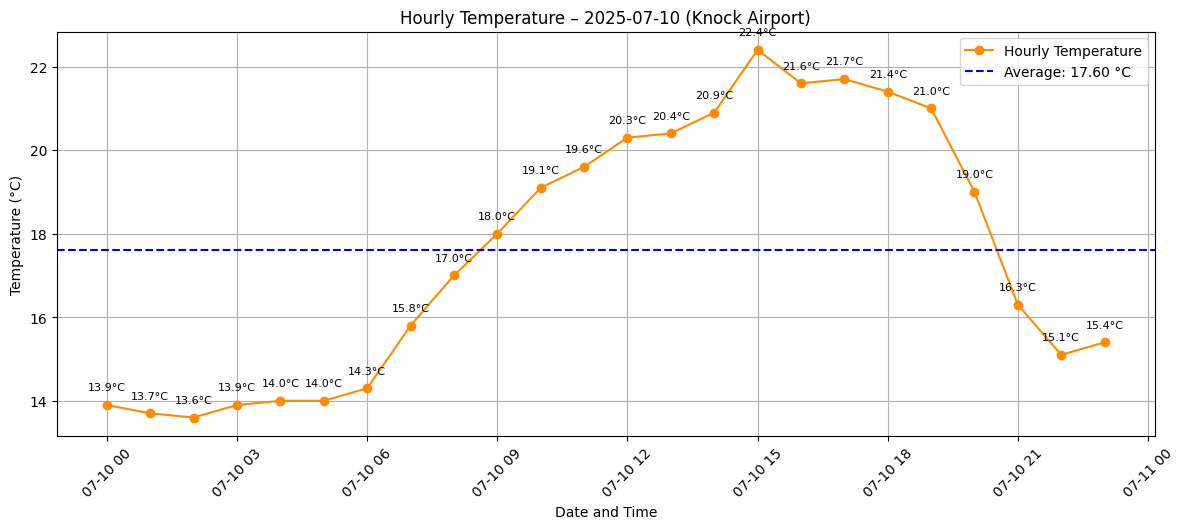


🧾 Hourly Ledger for 2025-07-10:
hour                  temp               
00:00                13.9                
01:00                13.7                
02:00                13.6                
03:00                13.9                
04:00                14.0                
05:00                14.0                
06:00                14.3                
07:00                15.8                
08:00                17.0                
09:00                18.0                
10:00                19.1                
11:00                19.6                
12:00                20.3                
13:00                20.4                
14:00                20.9                
15:00                22.4                
16:00                21.6                
17:00                21.7                
18:00                21.4                
19:00                21.0                
20:00                19.0                
21:00                16.3                
2

In [23]:
# 📌 Manual Daily Temperature Plot with Hourly Ledger
# NOTE: datetime (class) and pandas (pd) are already imported earlier in the notebook.

# Robustly determine input_date with safe fallbacks
fallback_date = datetime(2025, 7, 12).date()  # default if parsing fails

if 'custom_start' in globals() and custom_start is not None:
    try:
        # If custom_start is a pandas Timestamp or datetime-like, use .date()
        if hasattr(custom_start, 'date'):
            input_date = custom_start.date()
        else:
            ts = pd.to_datetime(custom_start, errors='coerce')
            input_date = ts.date() if not pd.isna(ts) else fallback_date
    except Exception:
        input_date = fallback_date
else:
    input_date = fallback_date

# Validate range_df before plotting
if 'range_df' not in globals() or range_df is None or range_df.empty:
    print("❌ No data available for the selected date range. Please check your previous steps.")
else:
    # Ensure we compare like-for-like dates: parse the 'date' column to python date objects
    parsed_dates = pd.to_datetime(range_df['date'], errors='coerce').dt.date
    if input_date not in parsed_dates.unique():
        print(f"❌ Date {input_date} not found in dataset. Available dates: {sorted(set(d for d in parsed_dates.dropna()))}")
    else:
        # Filter and plot for selected date
        mask = parsed_dates == input_date
        day_df = range_df.loc[mask].copy()
        if day_df.empty:
            print(f"❌ No hourly rows found for {input_date}.")
        else:
            avg_temp = day_df['temp'].mean()

            plt.figure(figsize=(12, 5))
            plt.plot(day_df['datetime'], day_df['temp'], label='Hourly Temperature', color='darkorange', marker='o')
            for x, y in zip(day_df['datetime'], day_df['temp']):
                plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)
            plt.axhline(avg_temp, color='blue', linestyle='--', label=f'Average: {avg_temp:.2f} °C')
            plt.title(f"Hourly Temperature – {input_date} (Knock Airport)")
            plt.xlabel("Date and Time")
            plt.ylabel("Temperature (°C)")
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.xticks(rotation=45)
            plt.show()

            print(f"\n🧾 Hourly Ledger for {input_date}:")
            print(day_df[['hour', 'temp']].round(1).to_string(index=False, justify='left', col_space=20))


## Generate Climate Data Mean Daily Summary (CSV only)

This section computes the daily mean temperature for Summer 2025 and saves it to a CSV file — no plotting.  This file can be used for further analysis or reporting as needed.  The daily mean temperatures are calculated for each day from June 1 to August 31, 2025, and the results are saved in a tidy CSV format.

https://www.met.ie/education/outreach-irish-seasons

In [29]:
# --- Prerequisite Checks ---
if 'seasons_2025' not in globals():
    raise RuntimeError("Missing seasonal boundaries: 'seasons_2025' is not defined.")
if 'df' not in globals():
    raise RuntimeError("Missing dataset: 'df' is not defined.")

# --- Clean and parse datetime and temperature using helpers ---
df.columns = df.columns.str.strip()
date_col = 'date' if 'date' in df.columns else next((c for c in df.columns if 'date' in c.lower()), None)
if date_col is None:
    raise RuntimeError("No date column found in the dataset.")

df['datetime'] = parse_datetime_column(df, date_col)  # from helpers
df = parse_temperature_column(df)  # from helpers

# --- Filter for Summer 2025 using seasonal bounds ---
summer_bounds = seasons_2025.loc[seasons_2025['season'].str.lower() == 'summer'].iloc[0]
start_date = pd.to_datetime(summer_bounds['start'])
end_date = pd.to_datetime(summer_bounds['end'])

summer_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
summer_df['date'] = summer_df['datetime'].dt.date

# --- Compute daily statistics ---
daily_stats = (
    summer_df.groupby('date')['temp']
    .agg(count='count', mean='mean', std='std')
    .reset_index()
)

daily_stats[['mean', 'std']] = daily_stats[['mean', 'std']].round(2)

# --- Save to CSV ---
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
out_fp = out_dir / "assignment06_climate_data_mean_daily_summer_2025.csv"
daily_stats.to_csv(out_fp, index=False)

# --- Display Output ---
print(f"✅ Saved daily temperature stats to: {out_fp}")
print("\n📋 First 20 rows of daily temperature summary:")
print(daily_stats.head(20).to_string(index=False))


✅ Detected datetime format: %d-%b-%Y %H:%M
✅ Saved daily temperature stats to: data\assignment06_climate_data_mean_daily_summer_2025.csv

📋 First 20 rows of daily temperature summary:
      date  count  mean  std
2025-06-01     24 11.19 1.85
2025-06-02     24 10.45 2.80
2025-06-03     24  9.40 1.49
2025-06-04     24 10.20 2.74
2025-06-05     24 10.28 2.00
2025-06-06     24 10.25 2.87
2025-06-07     24  9.56 1.75
2025-06-08     24 10.24 1.62
2025-06-09     24 11.61 1.48
2025-06-10     24 12.98 2.78
2025-06-11     24 14.40 2.32
2025-06-12     24 14.68 0.98
2025-06-13     24 15.23 1.64
2025-06-14     24 13.75 1.98
2025-06-15     24 13.90 2.13
2025-06-16     24 14.60 1.77
2025-06-17     24 14.92 1.94
2025-06-18     24 14.49 2.77
2025-06-19     24 17.59 5.35
2025-06-20     24 20.07 4.59


## 📈 Visualising Mean Temperatures for the Hottest Week of Summer 2025

This section loads the saved daily mean temperature data from CSV and plots values specifically for the hottest week of Summer 2025 — spanning 10th to 16th July. According to [BreakingNews.ie](https://www.breakingnews.ie/ireland/july-2025-was-9th-hottest-on-record-with-highest-temperature-of-31-degrees-1789636.html), July 2025 ranked as the 9th hottest on record, with temperatures peaking at 31°C.

✅ Saved plot: plots\assignment06_mean_daily_custom_range.png


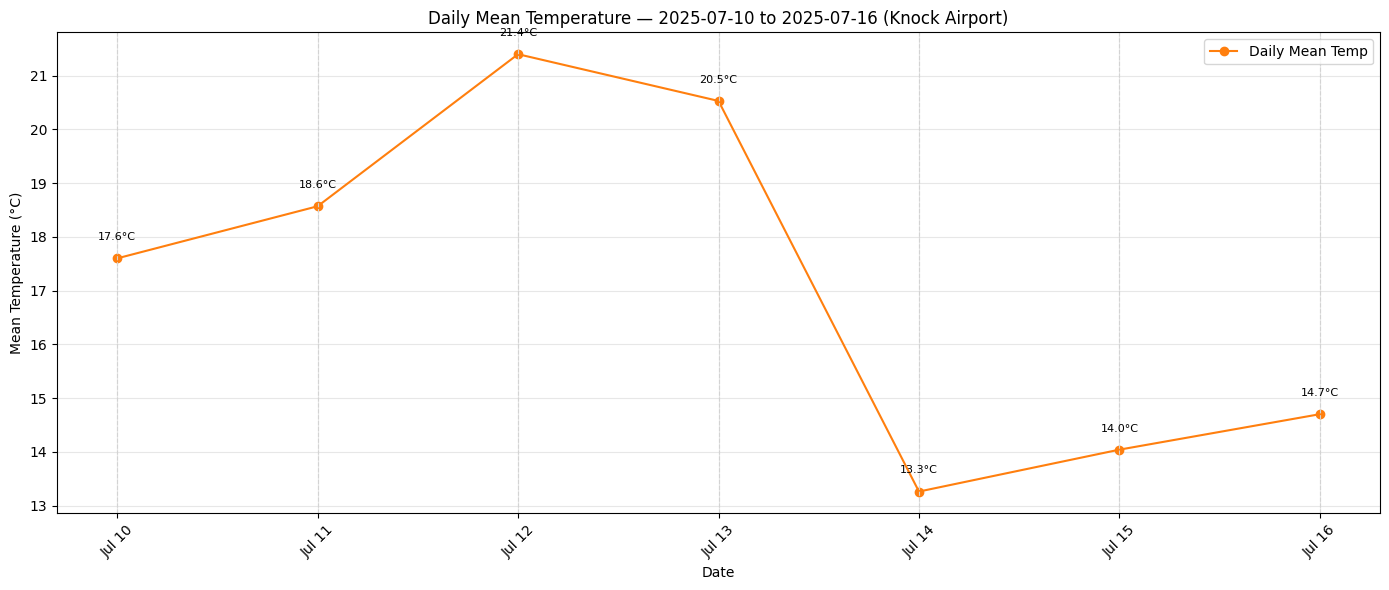


🧾 Daily Mean Ledger (2025-07-10 to 2025-07-16):
date                  mean               
2025-07-10           17.6                
2025-07-11           18.6                
2025-07-12           21.4                
2025-07-13           20.5                
2025-07-14           13.3                
2025-07-15           14.0                
2025-07-16           14.7                


In [30]:
# 📅 Resolve custom_start and custom_end using helper
start_ts, end_ts = get_custom_range(custom_start, custom_end)

# Apply fallback if helper returns None
if start_ts is None or end_ts is None:
    start_ts = pd.Timestamp("2025-07-10")
    end_ts = pd.Timestamp("2025-07-16 23:59")

# Extract date components
start_date = start_ts.date()
end_date = end_ts.date()

# 📥 Load daily mean CSV (file is saved in 'data/', not '../data/')
csv_fp = Path("data") / "assignment06_climate_data_mean_daily_summer_2025.csv"
if not csv_fp.exists():
    raise FileNotFoundError(f"Daily mean CSV not found at: {csv_fp.resolve()}")

daily_mean = pd.read_csv(csv_fp, parse_dates=['date'])

# 📅 Ensure full date coverage in custom range
full_dates = pd.date_range(start_date, end_date, freq='D')
full_df = pd.DataFrame({'date': full_dates})
custom_mean = full_df.merge(daily_mean, on='date', how='left')

if custom_mean.empty or custom_mean['mean'].dropna().empty:
    print(f"⚠️ No data found between {start_date} and {end_date}.")
else:
    # 📈 Plot
    plt.figure(figsize=(14, 6))
    plt.plot(custom_mean['date'], custom_mean['mean'], marker='o', color='tab:orange', label='Daily Mean Temp')

    for x, y in zip(custom_mean['date'], custom_mean['mean']):
        if pd.notna(y):
            plt.axvline(x=x, color='lightgray', linestyle='--', linewidth=0.8)
            plt.text(x, y + 0.3, f"{y:.1f}°C", ha='center', va='bottom', fontsize=8)

    plt.xticks(ticks=custom_mean['date'], labels=custom_mean['date'].dt.strftime('%b %d').tolist(), rotation=45)
    plt.title(f'Daily Mean Temperature — {start_date} to {end_date} (Knock Airport)')
    plt.xlabel('Date')
    plt.ylabel('Mean Temperature (°C)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

    # 💾 Save plot
    plots_dir = Path("plots")
    plots_dir.mkdir(parents=True, exist_ok=True)
    plot_fp = plots_dir / "assignment06_mean_daily_custom_range.png"
    plt.savefig(plot_fp, dpi=100)
    print(f'✅ Saved plot: {plot_fp}')
    plt.show()

    # 📋 Display ledger
    print(f"\n🧾 Daily Mean Ledger ({start_date} to {end_date}):")
    ledger = custom_mean[['date', 'mean']].copy()
    ledger['mean'] = ledger['mean'].round(1)
    print(ledger.to_string(index=False, justify='left', col_space=20))


## 📦 Monthly Mean Temperatures by Season (Winter, Spring, Summer & Autumn 2025)

The cell below calculates the monthly mean temperature for each month contained in the Winter, Spring and Summer 2025 season definitions found earlier in the notebook. Winter encompasses dates from December 2024 to February 2025, Spring from March to May 2025, and Summer from June to August 2025. It saves a tidy CSV `../data/monthly_mean_by_season_2025.csv` and a PNG plot `../plots/monthly_mean_by_season_2025.png` for further analysis.

### 🧮 Part 1:Compute Monthly Mean Temperature and Display Results

The following code computes the monthly mean temperature for the defined seasons and displays the results.

In [36]:
# 📊 Monthly Temperature Summary by Season (2025)

from pathlib import Path

# ✅ Ensure prerequisites
if 'seasons_2025' not in globals():
    raise RuntimeError("Missing seasonal boundaries: 'seasons_2025' is not defined.")
if 'df' not in globals():
    raise RuntimeError("Missing dataset: 'df' is not defined.")

# 🧼 Clean and parse datetime and temperature using helpers
df.columns = df.columns.str.strip()
date_col = 'date' if 'date' in df.columns else next((c for c in df.columns if 'date' in c.lower()), None)
df['datetime'] = parse_datetime_column(df, date_col)
df = parse_temperature_column(df)

# 📅 Seasons to analyse (in desired order)
seasons_of_interest = ['Winter', 'Spring', 'Summer', 'Autumn']
rows = []

for season in seasons_of_interest:
    season_row = seasons_2025.loc[seasons_2025['season'].str.lower() == season.lower()]
    if season_row.empty:
        print(f"⚠️ Season '{season}' not found in seasons_2025; skipping.")
        continue

    bounds = season_row.iloc[0]
    start = pd.to_datetime(bounds['start'])
    end = pd.to_datetime(bounds['end'])

    mask = (df['datetime'] >= start) & (df['datetime'] <= end)
    sub = df.loc[mask].dropna(subset=['datetime', 'temp']).copy()

    if sub.empty:
        print(f"⚠️ No data for {season} between {start.date()} and {end.date()}")
        continue

    sub['month'] = sub['datetime'].dt.to_period('M').dt.to_timestamp()
    monthly = sub.groupby('month')['temp'].agg(count='count', mean='mean', std='std').reset_index()
    monthly['season'] = season
    rows.append(monthly)

# 📁 Save and display results
if not rows:
    print("⚠️ No monthly data computed for the selected seasons.")
else:
    monthly_df = pd.concat(rows, ignore_index=True)

    # Enforce seasonal order
    seasonal_order = pd.CategoricalDtype(categories=seasons_of_interest, ordered=True)
    monthly_df['season'] = monthly_df['season'].astype(seasonal_order)

    monthly_df = monthly_df.sort_values(['season', 'month']).reset_index(drop=True)
    monthly_df[['mean', 'std']] = monthly_df[['mean', 'std']].round(2)

    out_dir = Path("data")
    out_dir.mkdir(parents=True, exist_ok=True)
    out_fp = out_dir / "assignment06_monthly_mean_by_season_2025.csv"
    monthly_df.to_csv(out_fp, index=False)

    print(f"✅ Saved monthly means CSV: {out_fp}")
    try:
        display(monthly_df)
    except Exception:
        print(monthly_df.to_string(index=False))


✅ Detected datetime format: %d-%b-%Y %H:%M
✅ Saved monthly means CSV: data\assignment06_monthly_mean_by_season_2025.csv


,month,count,mean,std,season
0,2024-12-01,744,6.38,3.02,Winter
1,2025-01-01,744,3.78,3.40,Winter
2,2025-02-01,672,5.06,2.70,Winter
3,2025-03-01,744,7.21,2.88,Spring
4,2025-04-01,720,9.80,4.02,Spring
5,2025-05-01,744,12.41,3.86,Spring
6,2025-06-01,720,13.43,3.41,Summer
7,2025-07-01,744,15.07,3.10,Summer
8,2025-08-01,744,15.18,2.91,Summer
9,2025-09-01,720,11.37,2.62,Autumn


### 📈 Part 2: Plot Monthly Mean Temperatures

This section visualises the monthly mean temperatures calculated for Winter, Spring, and Summer 2025. It generates a line plot to illustrate temperature trends across these seasons, highlighting seasonal variations and patterns. The plot is saved as a PNG file for further analysis and reporting.

Saved plot: plots\assignment06_monthly_mean_by_season_2025.png


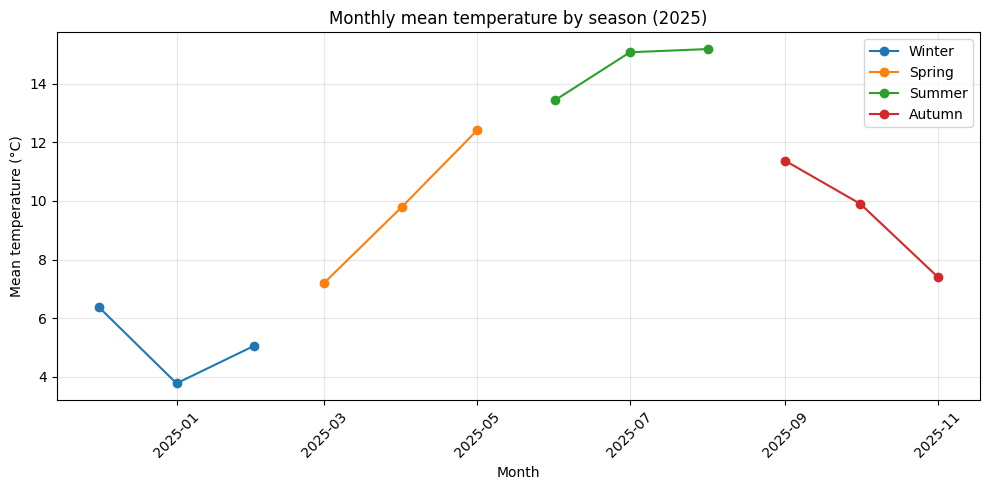

In [37]:
plt.figure(figsize=(10, 5))
for s in seasons_of_interest:
    sub = monthly_df[monthly_df['season'] == s]
    if sub.empty:
        continue
    plt.plot(sub['month'], sub['mean'], marker='o', label=s)

plt.title('Monthly mean temperature by season (2025)')
plt.xlabel('Month')
plt.ylabel('Mean temperature (°C)')
plt.grid(alpha=0.3)
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plots_dir = Path('plots')
plots_dir.mkdir(parents=True, exist_ok=True)
plot_fp = plots_dir / 'assignment06_monthly_mean_by_season_2025.png'
plt.savefig(plot_fp, dpi=150)
print(f'Saved plot: {plot_fp}')
plt.show()


## Windspeed Data Analysis

This section analyses the windspeed data from the Knock Airport weather dataset. It involves cleaning the data, parsing datetime information, and filtering for relevant windspeed measurements. The prepared dataset can then be used for further analysis or visualisation of wind patterns at Knock Airport.

In [41]:
# 🌬️ Clean Windspeed Data for Summer 2025

# ✅ Load cleaned weather data using helper
data_fp = Path("data") / "assignment06_climate_data.csv"
if not data_fp.exists():
    raise FileNotFoundError(f"❌ Climate data file not found at: {data_fp.resolve()}")

# Pass a string path to satisfy type checkers and ensure compatibility
df = load_cleaned_weather_data(str(data_fp))  # from helpers

# ✅ Parse datetime using helper
date_col = 'date' if 'date' in df.columns else next((c for c in df.columns if 'date' in c.lower()), None)
if date_col is None:
    raise KeyError("❌ No date column found in dataset.")
df['datetime'] = parse_datetime_column(df, date_col)  # from helpers

# ✅ Parse windspeed column
if 'wdsp' not in df.columns:
    raise KeyError("❌ Missing 'wdsp' column for windspeed.")
df['windspeed'] = pd.to_numeric(df['wdsp'], errors='coerce')

# ✅ Ensure seasonal boundaries are available (bind variable deterministically)
seasons_2025 = globals().get('seasons_2025')
if seasons_2025 is None:
    # define_irish_seasons is provided in the helpers cell
    seasons_2025 = define_irish_seasons(2025)

# Now safely select the summer row
summer_row = seasons_2025.loc[seasons_2025['season'].str.lower() == 'summer']
if summer_row.empty:
    raise RuntimeError("❌ Summer season not found in seasons_2025.")

start = pd.to_datetime(summer_row.iloc[0]['start'])
end = pd.to_datetime(summer_row.iloc[0]['end'])

# ✅ Filter and clean summer windspeed data
summer_df = df[(df['datetime'] >= start) & (df['datetime'] <= end)].copy()
summer_df = summer_df.dropna(subset=['windspeed'])

# 💾 Save to CSV in the shared ../data location so downstream cells can find it
out_dir = Path("data")
out_dir.mkdir(parents=True, exist_ok=True)
out_fp = out_dir / "assignment06_windspeed_cleaned_summer_2025.csv"
summer_df.to_csv(out_fp, index=False)

print(f"✅ Saved cleaned windspeed data for Summer 2025: {out_fp.resolve()}")


✅ Detected datetime format: %d-%b-%Y %H:%M
✅ Saved cleaned windspeed data for Summer 2025: C:\Users\eCron\OneDrive\Documents\ATU_CourseWork\Programming For Data Analytics\programming-for-data-analytics\assignments\data\assignment06_windspeed_cleaned_summer_2025.csv


### 🌬️ Windspeed Cleaning and Missing Data Handling

To prepare the windspeed data for analysis, we extract the `wdsp` column — which contains hourly mean windspeed in knots — and convert it to numeric format using:

```python
df['windspeed'] = pd.to_numeric(df['wdsp'], errors='coerce')
```

We then remove rows with missing windspeed values
```python
summer_df = summer_df.dropna(subset=['windspeed'])
```
This conversion handles any non-numeric entries by coercing them to `NaN`, allowing us to identify and manage missing data effectively. After conversion, we filter the dataset to include only valid windspeed measurements for Summer 2025, dropping any rows with missing values. The cleaned dataset is then saved to a CSV file for future analysis.


### Windspeed Analysis — 10–16 July 2025

This section performs analysis and visualisation of the cleaned windspeed data from Knock Airport, specifically focusing on the date range **10th July 2025 to 16th July 2025**. This period aligns with the temperature analysis previously conducted and allows for a targeted examination of wind behaviour during a known heatwave.

The analysis includes:
- Calculating summary statistics
- Plotting hourly windspeed trends across each day
- Identifying patterns or anomalies in the dataset

The visualisations help to understand wind behaviour at the airport during the specified period, including diurnal variations and potential correlations with temperature.

Null data points were removed in the previous cleaning step to ensure accurate analysis. This follows best practice in data science, where removing missing values before aggregation helps maintain data integrity and avoids misleading results.

> [w3schools.com](https://w3schools.com/pandas/pandas_handling_missing_data.asp) notes that removing missing values before analysis is a common practice to ensure data integrity.


In [ ]:
# 📥 Load cleaned windspeed data for Summer 2025
file_path = os.path.join("..", "data", "windspeed_cleaned_summer_2025.csv")
df = pd.read_csv(file_path)

# 🧼 Ensure datetime column is parsed
if 'datetime' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# 📆 Filter using custom_start and custom_end
focus_df = df[(df['datetime'] >= custom_start) & (df['datetime'] <= custom_end)].copy()

# 🗓️ Extract date and hour for grouping
focus_df['date'] = focus_df['datetime'].dt.date
focus_df['hour'] = focus_df['datetime'].dt.strftime('%H:%M')

# 📊 Create pivot table: hourly windspeed across selected dates
pivot = focus_df.pivot_table(index='hour', columns='date', values='windspeed', aggfunc='mean')

# 💾 Save pivot table as CSV
pivot_table_fp = os.path.join("..", "data", f"windspeed_hourly_table_{custom_start.date()}_to_{custom_end.date()}.csv")
pivot.to_csv(pivot_table_fp)
print(f"Saved hourly windspeed table: {pivot_table_fp}")

# 📈 Plot hourly windspeed trends
plt.figure(figsize=(12, 6))
for date in pivot.columns:
    plt.plot(pivot.index, pivot[date], label=str(date))

plt.title(f"Hourly Mean Windspeed (knots) — {custom_start.date()} to {custom_end.date()}")
plt.xlabel("Hour of Day")
plt.ylabel("Windspeed (knots)")
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()

# 💾 Save plot
plots_dir = os.path.join("..", "plots")
os.makedirs(plots_dir, exist_ok=True)
plot_fp = os.path.join(plots_dir, f"windspeed_hourly_{custom_start.date()}_to_{custom_end.date()}.png")
plt.savefig(plot_fp, dpi=150)
print(f"Saved plot: {plot_fp}")
plt.show()

# 📋 Output the windspeed pivot table
print("\nHourly Mean Windspeed Table:")
display(pivot)

## Step 3 Rolling windspeed (24 hours)

This section calculates a 24-hour rolling average of windspeed data from Knock Airport. The rolling average smooths out short-term fluctuations and highlights longer-term trends in wind behaviour.  The time frame for this analysis is from 10th July 2025 to 16th July 2025, aligning with the previous temperature and windspeed analyses.  24 hour rolling averages commence at 00:00 hrs and end at 23:59 hours each day.

In [ ]:
# 📥 Load cleaned windspeed data for Summer 2025
file_path = os.path.join("..", "data", "windspeed_cleaned_summer_2025.csv")
df = pd.read_csv(file_path)

# 🧼 Ensure datetime column is parsed
if 'datetime' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# 📅 Input date for analysis
input_date = pd.Timestamp("2025-07-15")  # Change this date as needed
custom_start = input_date.replace(hour=0, minute=0)
custom_end = input_date.replace(hour=23, minute=59)

# 📆 Filter using custom_start and custom_end
focus_df = df[(df['datetime'] >= custom_start) & (df['datetime'] <= custom_end)].copy()

# 🗓️ Extract date and hour for grouping
focus_df['date'] = focus_df['datetime'].dt.date
focus_df['hour'] = focus_df['datetime'].dt.strftime('%H:%M')

# 📊 Create pivot table: hourly windspeed for selected date
pivot = focus_df.pivot_table(index='hour', columns='date', values='windspeed', aggfunc='mean')

# 💾 Save pivot table as CSV
pivot_table_fp = os.path.join("..", "data", f"windspeed_hourly_table_{custom_start.date()}_to_{custom_end.date()}.csv")
pivot.to_csv(pivot_table_fp)
print(f"✅ Saved hourly windspeed table: {pivot_table_fp}")

# 📈 Plot hourly windspeed trends
plt.figure(figsize=(12, 6))
for date in pivot.columns:
    plt.plot(pivot.index, pivot[date], label=str(date))

plt.title(f"Hourly Mean Windspeed (knots) — {custom_start.date()}")
plt.xlabel("Hour of Day")
plt.ylabel("Windspeed (knots)")
plt.grid(True, alpha=0.3)
plt.legend(loc='upper right', fontsize='small')
plt.xticks(rotation=45)
plt.tight_layout()

# 💾 Save plot
plots_dir = os.path.join("..", "plots")
os.makedirs(plots_dir, exist_ok=True)
plot_fp = os.path.join(plots_dir, f"windspeed_hourly_{custom_start.date()}.png")
plt.savefig(plot_fp, dpi=150)
print(f"✅ Saved plot: {plot_fp}")
plt.show()

# 📋 Output the windspeed pivot table
print("\nHourly Mean Windspeed Table:")
display(pivot)


## Step 4: Max windspeed for each day

### 💻 Generate and Save Daily Max Windspeed Table

In [ ]:
# 📥 Load cleaned windspeed data for Summer 2025
file_path = os.path.join("..", "data", "windspeed_cleaned_summer_2025.csv")
df = pd.read_csv(file_path)

# 🧼 Ensure datetime column is parsed
if 'datetime' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# 📆 Define focus week: 10–16 July 2025
start_date = pd.Timestamp("2025-07-10 00:00")
end_date = pd.Timestamp("2025-07-16 23:59")

# 📊 Filter and compute daily max windspeed and time
week_df = df[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
week_df['date'] = week_df['datetime'].dt.date

# Find max windspeed and time for each day
daily_max_rows = (
    week_df.loc[week_df.groupby('date')['windspeed'].idxmax()]
    .sort_values('date')
    .reset_index(drop=True)
)

# Format output
daily_max_rows['windspeed'] = daily_max_rows['windspeed'].round(2)
daily_max_rows['time_of_max'] = daily_max_rows['datetime'].dt.strftime('%H:%M')

# Select and rename columns
daily_max_summary = daily_max_rows[['date', 'windspeed', 'time_of_max']]
daily_max_summary.columns = ['date', 'max_windspeed', 'time_of_max']

# 💾 Save results
out_dir = os.path.join("..", "data")
os.makedirs(out_dir, exist_ok=True)
out_fp = os.path.join(out_dir, "daily_max_windspeed_with_time_10_16_July_2025.csv")
daily_max_summary.to_csv(out_fp, index=False)

# 📋 Display results
print(f"✅ Saved daily max windspeed summary with time: {out_fp}")
print("\n📈 Daily Max Windspeed and Time (10–16 July 2025):")
print(daily_max_summary.to_string(index=False))


### 📊 Plot Daily Max Windspeed with Time

In [ ]:
# 📥 Load the saved summary
summary_fp = os.path.join("..", "data", "daily_max_windspeed_with_time_10_16_July_2025.csv")
df = pd.read_csv(summary_fp)

# 🔢 Sort by date to ensure correct line order
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 🎨 Create line plot
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['max_windspeed'], marker='o', linestyle='-', color='royalblue')

# 🕒 Annotate each point with windspeed and time
for x, y, time in zip(df['date'], df['max_windspeed'], df['time_of_max']):
    plt.text(x, y + 0.3, f"{y} knots\n@ {time}", ha='center', va='bottom', fontsize=9)

plt.title("🌬️ Daily Max Windspeed — 10–16 July 2025")
plt.xlabel("Date")
plt.ylabel("Max Windspeed (knots)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# 💾 Save plot
plots_dir = os.path.join("..", "plots")
os.makedirs(plots_dir, exist_ok=True)
plot_fp = os.path.join(plots_dir, "daily_max_windspeed_line_10_16_July_2025.png")
plt.savefig(plot_fp, dpi=150)
print(f"✅ Saved line plot: {plot_fp}")
plt.show()


## Step 5: Monthly Mean of Daily Max Windspeeds (July 2025)

In [ ]:
# 📥 Load cleaned windspeed data for Summer 2025
file_path = os.path.join("..", "data", "windspeed_cleaned_summer_2025.csv")
df = pd.read_csv(file_path)

# 🧼 Ensure datetime column is parsed
if 'datetime' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['datetime']):
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')

# 📆 Filter for July 2025
july_start = pd.Timestamp("2025-07-01 00:00")
july_end = pd.Timestamp("2025-07-31 23:59")
july_df = df[(df['datetime'] >= july_start) & (df['datetime'] <= july_end)].copy()

# 🗓️ Extract date for daily grouping
july_df['date'] = july_df['datetime'].dt.date

# 📊 Compute daily max windspeed
daily_max = july_df.groupby('date')['windspeed'].max().reset_index()
daily_max['windspeed'] = daily_max['windspeed'].round(2)

# 📈 Compute monthly mean of daily max values
# Use built-in round() on the resulting float to avoid calling .round on a float object
monthly_mean = round(daily_max['windspeed'].mean(), 2)

# 💾 Save daily max and monthly mean to CSV
out_dir = os.path.join("..", "data")
os.makedirs(out_dir, exist_ok=True)
daily_fp = os.path.join(out_dir, "daily_max_windspeed_July_2025.csv")
summary_fp = os.path.join(out_dir, "monthly_mean_of_daily_max_windspeed_July_2025.csv")

daily_max.to_csv(daily_fp, index=False)
pd.DataFrame([{'month': 'July 2025', 'mean_daily_max_windspeed': monthly_mean}]).to_csv(summary_fp, index=False)

# 📋 Display results
print(f"✅ Saved daily max windspeed: {daily_fp}")
print(f"✅ Saved monthly mean of daily max windspeed: {summary_fp}")
print(f"\n📈 Monthly Mean of Daily Max Windspeed (July 2025): {monthly_mean} knots")


### Plot Monthly Mean of Daily Max Windspeeds (July 2025)

In [ ]:
# 📥 Load daily max windspeed data for July 2025
daily_fp = os.path.join("..", "data", "daily_max_windspeed_July_2025.csv")
df = pd.read_csv(daily_fp)

# 🧼 Ensure date column is parsed
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# 📈 Calculate monthly mean of daily max windspeed
monthly_mean = round(df['windspeed'].mean(), 2)

# 🎨 Create line plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['windspeed'], marker='o', linestyle='-', color='royalblue', label='Daily Max Windspeed')
plt.axhline(monthly_mean, color='darkorange', linestyle='--', linewidth=2, label=f'Monthly Mean: {monthly_mean} knots')

# 🕒 Annotate each point with value
for x, y in zip(df['date'], df['windspeed']):
    plt.text(x, y + 0.3, f"{y}", ha='center', va='bottom', fontsize=8)

plt.title("🌬️ Daily Max Windspeed — July 2025")
plt.xlabel("Date")
plt.ylabel("Max Windspeed (knots)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# 💾 Save plot
plots_dir = os.path.join("..", "plots")
os.makedirs(plots_dir, exist_ok=True)
plot_fp = os.path.join(plots_dir, "daily_max_windspeed_with_monthly_mean_July_2025.png")
plt.savefig(plot_fp, dpi=150)
print(f"✅ Saved plot with monthly mean line: {plot_fp}")
plt.show()
